## Feature extraction from images using a Restricted Boltzmann Machine; this dataset was designed as a more robust and challenging replacement for the overused MNIST digit set.
## It's similar, but is a set of fashion images, which are not as straightforward as the regular handwritten digits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import convolve
from sklearn.neural_network import BernoulliRBM
import seaborn as sns

In [2]:
# For loading the MNIST-fashion data, stolen from the authors of the dataset itself
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('/home/aaron/work/Python/environs/jupyter/projects/neurals', kind='train')

# the following are actually unused in this exercise
X_test, y_test = load_mnist('/home/aaron/work/Python/environs/jupyter/projects/neurals', kind='t10k')

In [4]:
# dataframe for ease of use, visualization
df = pd.DataFrame(X_train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
labels = pd.DataFrame(y_train)
labels.rename(columns={0:'label'}, inplace=True)

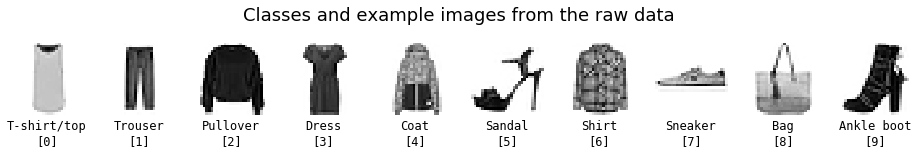

In [6]:
### Visualizing the categories

# Define the category labels
cat_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

def plot_classes(column, title='Images'):
    plt.figure(figsize=(13,4))
    gs = GridSpec(1, 10)
    for label in range(0,10):    
        ax = plt.subplot(gs[0, 0+label:1+label])
        plt.imshow(list(visualization[visualization['label'] == label][column][0:10])[1], 
                   cmap=plt.cm.Greys)
        plt.title('{}\n[{}]'.format(cat_labels[label], label), y=-0.5, fontsize=12, family='monospace')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        sns.despine(bottom=True, left=True)
    plt.suptitle(title, y=0.75, fontsize=18)
    plt.tight_layout()
    plt.show()
    
# Create a new dataframe with a column of numpy arrays that summarize the pixel data
visualization = pd.DataFrame()
visualization['label'] = labels['label']
visualization['images_raw'] = list(item for item in df.values)
visualization['images_raw'] = visualization['images_raw'].apply(lambda x: x.reshape(28,28))

# Plot
plot_classes('images_raw', 'Classes and example images from the raw data')
plt.show()

## Prepare data: everyone I can find online and in Scikit Learn's RBM tutorial does this 1-pixel shift, which quintuples the size of the dataset.
## Additionally, rescale all of the data to better work in the RBM (needs binary inputs 0-1)

In [7]:
# Nudge function, everyone seems to do this, including the Scikit Learn tutorial
def nudge_dataset(X, Y):
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((28, 28)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Here's the dataset before transformations (X_train generated above)
print('The raw dataset contains {} observations.'.format(X_train.shape[0]))

# Rescale and nudge X
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001) 
X_train, y_train = nudge_dataset(X_train, labels['label'])
print('With the addition of the nudged data, the dataset contains {} observations.'.format(X_train.shape[0]))

The raw dataset contains 60000 observations.
With the addition of the nudged data, the dataset contains 300000 observations.


## GridSearchCV would be the right way to find good parameters, which is a complex and very intensive process.

In [8]:
# Instantiate and fit the model
rbm = BernoulliRBM(n_components=100, 
                   learning_rate=0.5,
                   verbose=True)

rbm.fit(X_train, y_train)
rbm_X = rbm.transform(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -315.76, time = 67.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -310.82, time = 73.90s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -332.23, time = 71.50s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -336.59, time = 72.67s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -334.46, time = 71.91s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -303.89, time = 73.49s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -334.20, time = 70.68s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -339.81, time = 73.14s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -356.15, time = 69.26s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -337.54, time = 70.89s


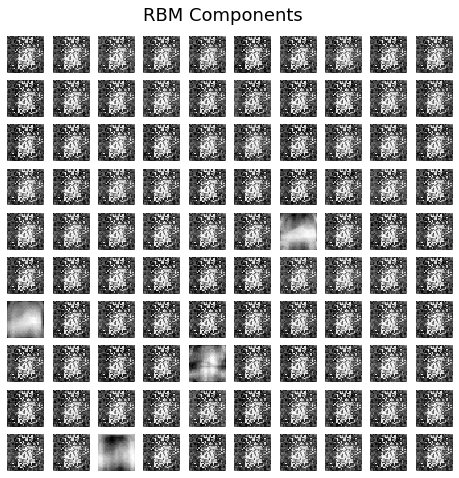

In [9]:
# Retrieve the RBM components
components = rbm.components_

plt.figure(figsize=(8,8))
for x in range(0,100):
    ax = plt.subplot(10, 10, x + 1)
    plt.imshow(components[x].reshape(28,28), cmap=plt.cm.Greys)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    sns.despine(bottom=True, left=True)

plt.suptitle('RBM Components', y=0.93, fontsize=18)
plt.show()


## Overview
### Our Restricted Boltzmann Machine was able to condense image data down from large arrays of pixels into substantially fewer & more meaningful dimensions, making it more suitable for further modeling.  However, it's difficult for me to actually understand this process well.

## Questions
- Many of my components looked like very similar (actually the same) noise, while others very clearly distinguish characteristics of the garments in the dataset. Why? Are the components that look like noise actually noise, or what is the machine picking up on?  Other than possibly slight greyscale changes, I can't distinguish them from one another.

- Are there better methodical ways to set hyperparameters than piping the RBM output into a predictive model and using GridSearchCV? Just experience and experimentation, and a big set of computers?

- How does one really know that this is meaningful, other than it greatly reduced the size?